## Troisième Partie : Simulation

#### Importation des Packages

In [1]:
# Importation des bibliothèques standard
import os
from time import time
import warnings
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from plotly.offline import download_plotlyjs, init_notebook_mode, iplot
import plotly.graph_objs as go
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.decomposition import PCA
from sklearn.metrics import homogeneity_score, adjusted_rand_score, adjusted_mutual_info_score
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.pipeline import Pipeline
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import QuantileTransformer 
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import PowerTransformer

# Importation des bibliothèques de clustering
from sklearn.cluster import KMeans
from sklearn.cluster import MeanShift, estimate_bandwidth
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer, InterclusterDistance
from kmodes.kprototypes import KPrototypes


mpl.rcParams["figure.figsize"] = (12, 8)
init_notebook_mode()
warnings.filterwarnings('ignore')

pd.set_option("display.max_rows", 101)
pd.options.display.max_columns = 999

#### Chargement de datasets

In [2]:
# On affiche les chemins menant à nos datasets.
data = pd.read_csv('data-clean-modelisation.csv')
data.head()

Unnamed: 0                customer_unique_id  nombre_de_commandes  \
0           0  0000366f3b9a7992bf8c76cfdf3221e2                    1   
1           1  0000b849f77a49e4a4ce2b2a4ca5be3f                    1   
2           2  0000f46a3911fa3c0805444483337064                    1   
3           3  0000f6ccb0745a6a4b88665a16c9f078                    1   
4           4  0004aac84e0df4da2b147fca70cf8255                    1   

   note_par_commande date_derniere_commande  paye_par_commande  \
0             135.90    2018-05-10 10:56:27                1.0   
1              21.90    2018-05-07 11:11:27                1.0   
2              95.00    2017-03-10 21:05:03                1.0   
3              45.99    2017-10-12 20:29:41                1.0   
4             193.00    2017-11-14 19:45:42                1.0   

   nb_paye_par_commande  mean_note_de_commentaire  mean_taille_de_commentaire  \
0                   8.0                       5.0                       111.0   
1                   1.0                       4.0                         0.0   
2                   8.0                       3.0                         0.0   
3                   4.0                       4.0                        12.0   
4                   6.0                       5.0                         0.0   

   mois_de_vente  mean_nombre_articles  mean_délai_de_commande  \
0              5                   1.0                   111.0   
1              5                   1.0                   114.0   
2              3                   1.0                   537.0   
3             10                   1.0                   321.0   
4             11                   1.0                   288.0   

   livraison_par_commande  mean_prix_commande  customer_zip_code_prefix  \
0                    0.04              129.90                      7787   
1                    0.14               18.90                      6053   
2                    0.27               69.00                     88115   
3                    0.43               25.99                     66812   
4                    0.07              180.00                     18040   

  customer_city customer_state  
0       cajamar             SP  
1        osasco             SP  
2      sao jose             SC  
3         belem             PA  
4      sorocaba             SP

In [3]:
# Supression de la colonne Unnamed: 31
del(data['Unnamed: 0'])

In [4]:
# On supprime les colonnes indiquées du jeu de données "data_test".
data.drop(["customer_zip_code_prefix",
           "customer_city",
           "customer_state"], axis=1, inplace=True)

In [5]:
# On affiche les cinq(5) premières lignes
data.head()

customer_unique_id  nombre_de_commandes  note_par_commande  \
0  0000366f3b9a7992bf8c76cfdf3221e2                    1             135.90   
1  0000b849f77a49e4a4ce2b2a4ca5be3f                    1              21.90   
2  0000f46a3911fa3c0805444483337064                    1              95.00   
3  0000f6ccb0745a6a4b88665a16c9f078                    1              45.99   
4  0004aac84e0df4da2b147fca70cf8255                    1             193.00   

  date_derniere_commande  paye_par_commande  nb_paye_par_commande  \
0    2018-05-10 10:56:27                1.0                   8.0   
1    2018-05-07 11:11:27                1.0                   1.0   
2    2017-03-10 21:05:03                1.0                   8.0   
3    2017-10-12 20:29:41                1.0                   4.0   
4    2017-11-14 19:45:42                1.0                   6.0   

   mean_note_de_commentaire  mean_taille_de_commentaire  mois_de_vente  \
0                       5.0                       111.0              5   
1                       4.0                         0.0              5   
2                       3.0                         0.0              3   
3                       4.0                        12.0             10   
4                       5.0                         0.0             11   

   mean_nombre_articles  mean_délai_de_commande  livraison_par_commande  \
0                   1.0                   111.0                    0.04   
1                   1.0                   114.0                    0.14   
2                   1.0                   537.0                    0.27   
3                   1.0                   321.0                    0.43   
4                   1.0                   288.0                    0.07   

   mean_prix_commande  
0              129.90  
1               18.90  
2               69.00  
3               25.99  
4              180.00

### Stabilité clusters

In [6]:
# Convertir les colonnes de dates en objets Timestamp si elles ne le sont pas déjà
data['date_derniere_commande'] = pd.to_datetime(data['date_derniere_commande'])

# Définir la date de début comme le 1er janvier 2017
date_debut = pd.to_datetime('2017-01-01')

# Calculer la date de fin en ajoutant 180 jours à la date de début
date_fin = date_debut + pd.Timedelta(days=180)

# Filtrer les données en fonction de la plage de dates définie
filter_date = (data['date_derniere_commande'] > date_debut) & (data['date_derniere_commande'] < date_fin)

# Copier les données qui correspondent à la plage de dates dans un nouveau DataFrame
data = data[filter_date].copy()

#### Calculons l'indice ARI moyen qui mesure la stabilité des clusters.

In [7]:
# Copier les colonnes pertinentes du DataFrame "data" dans un nouveau DataFrame "data_cluster"
data_cluster = data[['nombre_de_commandes','note_par_commande','paye_par_commande','mean_délai_de_commande',
                     'livraison_par_commande','nb_paye_par_commande','mean_note_de_commentaire','mean_taille_de_commentaire','mois_de_vente','mean_nombre_articles',
                     'mean_délai_de_commande','livraison_par_commande','mean_prix_commande']].copy()

# Appliquer la transformation log(1+x) sur les deux colonnes 
data_cluster['paye_par_commande'] = np.log1p(data_cluster['paye_par_commande'])
data_cluster['mean_délai_de_commande'] = np.log1p(data_cluster['mean_délai_de_commande'])

# Copier les colonnes transformées dans un nouveau DataFrame
transformed_columns = data_cluster[['paye_par_commande', 'mean_délai_de_commande', 'livraison_par_commande']].copy()

# Appliquer la transformation QuantileTransformer aux colonnes copiées
transformed_columns = QuantileTransformer(n_quantiles=5).fit_transform(transformed_columns)

# Remplacer les colonnes d'origine dans le DataFrame data_cluster par les colonnes transformées
data_cluster[['paye_par_commande', 'mean_délai_de_commande', 'livraison_par_commande']] = transformed_columns

# Appliquer la transformation Min-Max aux données standardisées (X_std)
X_std = MinMaxScaler().fit_transform(data_cluster)

# Initialiser un dictionnaire pour stocker les labels de cluster de différents modèles K-Means
dict_km={}

# Boucle sur 50 itérations pour créer des modèles K-Means
for i in range(1,51):
    # Initialiser un modèle K-Means avec 8 clusters
    km = KMeans(n_clusters=8)
    # Entraîner le modèle K-Means sur les données standardisées (X_std)
    km.fit(X_std)
    # Stocker les labels de cluster dans le dictionnaire avec une clé unique (de 1 à 50)
    dict_km[i] = km.labels_
# Initialiser une liste pour stocker les indices ARI de stabilité entre les clusters de différents modèles    
stab_clust = []
# Comparer les labels de cluster pour calculer l'indice ARI de stabilité
for cle in dict_km.keys():
    for i in range(cle+1,51):
        # Calculer l'indice ARI entre les clusters de deux modèles
        ari = adjusted_rand_score(dict_km[cle], dict_km[i])
        # Ajouter l'ARI à la liste de stabilité
        stab_clust.append(ari)

# Calculer la moyenne des indices ARI pour évaluer la stabilité des clusters
print('ARI moyen : ', np.array(stab_clust).mean())

ARI moyen :  0.8229247468453338


In [8]:
# Initialiser un dictionnaire pour stocker les labels de cluster de différents modèles
dict_km={}

# Boucle sur 50 itérations pour créer des modèles K-Means
for i in range(1,51):
    # Initialiser un modèle K-Means avec 8 clusters, une initialisation 'k-means++' et une seule initialisation
    km = KMeans(n_clusters=8, 
                init='k-means++', 
                n_init=1)
    # Entraîner le modèle K-Means sur les données standardisées (X_std)
    km.fit(X_std)
    # Stocker les labels de cluster dans le dictionnaire avec une clé unique (de 1 à 50)
    dict_km[i] = km.labels_
# Initialiser une liste pour stocker les indices ARI de stabilité entre les clusters de différents modèles    
stab_clust = []
# Comparer les labels de cluster pour calculer l'indice ARI de stabilité
for cle in dict_km.keys():
    for i in range(cle+1,51):
         # Calculer l'indice ARI entre les clusters de deux modèles
        ari = adjusted_rand_score(dict_km[cle], dict_km[i])
        # Ajouter l'ARI à la liste de stabilité
        stab_clust.append(ari)

# Calculer la moyenne des indices ARI pour évaluer la stabilité des clusters
print('ARI moyen : ', np.array(stab_clust).mean())

ARI moyen :  0.6830535632287762


In [9]:
# Initialiser un dictionnaire pour stocker les labels de cluster de différents modèles
dict_km={}

# Boucle sur 50 itérations pour créer des modèles K-Means
for i in range(1,51):
    # Initialiser un modèle K-Means avec 8 clusters, une initialisation aléatoire et une seule initialisation
    km = KMeans(n_clusters=8,
                init='random',
                n_init=1)
    # Entraîner le modèle K-Means sur les données standardisées (X_std)
    km.fit(X_std)
    # Stocker les labels de cluster dans le dictionnaire avec une clé unique (de 1 à 50)
    dict_km[i] = km.labels_
# Initialiser une liste pour stocker les indices ARI de stabilité entre les clusters de différents modèles    
stab_clust = []
# Comparer les labels de cluster pour calculer l'indice ARI de stabilité
for cle in dict_km.keys():
    for i in range(cle+1,51):
        # Calculer l'indice ARI entre les clusters de deux modèles
        ari = adjusted_rand_score(dict_km[cle], dict_km[i])
        # Ajouter l'ARI à la liste de stabilité
        stab_clust.append(ari)

# Calculer la moyenne des indices ARI pour évaluer la stabilité des clusters
print('ARI moyen : ', np.array(stab_clust).mean())

ARI moyen :  0.6535895118713995


### Contrat de maintenance Cluster

In [10]:
# Convertir toutes les colonnes du DataFrame en numérique
data_cluster = data.apply(pd.to_numeric, errors='coerce')

#### Entraînement du premier modèle.


Nous préparons les données, standardise et transforme certaines variables, puis entraîne un modèle K-Means avec 8 clusters sur ces données. Les labels de cluster prédits sont ajoutés aux données d'origine.

In [11]:
# Définir la période de référence pour l'entraînement du premier modèle
date_fin = pd.to_datetime('2018-05-31')
date_debut = date_fin - pd.Timedelta(days=180)

# Copier les colonnes pertinentes du DataFrame "data" dans un nouveau DataFrame "data_cluster"
data_cluster = data[['nombre_de_commandes','note_par_commande','paye_par_commande','mean_délai_de_commande',
                     'livraison_par_commande','nb_paye_par_commande','mean_note_de_commentaire','mean_taille_de_commentaire','mois_de_vente','mean_nombre_articles',
                     'mean_délai_de_commande','livraison_par_commande','mean_prix_commande']].copy()

# Appliquer la transformation log(1+x) sur les deux colonnes 
data_cluster['paye_par_commande'] = np.log1p(data_cluster['paye_par_commande'])
data_cluster['mean_délai_de_commande'] = np.log1p(data_cluster['mean_délai_de_commande'])

# Copier les colonnes transformées dans un nouveau DataFrame
transformed_columns = data_cluster[['paye_par_commande', 'mean_délai_de_commande', 'livraison_par_commande']].copy()

# Appliquer la transformation QuantileTransformer aux colonnes copiées
transformed_columns = QuantileTransformer(n_quantiles=5).fit_transform(transformed_columns)

# Remplacer les colonnes d'origine dans le DataFrame data_cluster par les colonnes transformées
data_cluster[['paye_par_commande', 'mean_délai_de_commande', 'livraison_par_commande']] = transformed_columns

# Appliquer la transformation Min-Max aux données standardisées (X_std)
X_std = MinMaxScaler().fit_transform(data_cluster)

# Initialiser le modèle de clustering K-Means avec 8 clusters
km = KMeans(n_clusters=8)

# Entraîner le modèle sur les données standardisées
km.fit(X_std)
# Ajouter les labels de cluster aux données originales
data_cluster['cluster'] = km.labels_


#### Création du jeu de données de test et première prédiction.

Nous préparons un jeu de test en appliquant des transformations aux données, puis en utilisant un modèle de clustering (km) pour prédire les clusters correspondants aux données du jeu de test

In [12]:
# Définir la période de début et de fin pour le jeu de test
date_debut = pd.to_datetime('2018-06-01')
date_fin = pd.to_datetime('2018-06-30')

# Copier les colonnes pertinentes du DataFrame "data" dans un nouveau DataFrame "data_cluster"
data_cluster = data[['nombre_de_commandes','note_par_commande','paye_par_commande','mean_délai_de_commande',
                     'livraison_par_commande','nb_paye_par_commande','mean_note_de_commentaire','mean_taille_de_commentaire','mois_de_vente','mean_nombre_articles',
                     'mean_délai_de_commande','livraison_par_commande','mean_prix_commande']].copy()

# Appliquer la transformation log(1+x) sur les deux colonnes 
data_cluster['paye_par_commande'] = np.log1p(data_cluster['paye_par_commande'])
data_cluster['mean_délai_de_commande'] = np.log1p(data_cluster['mean_délai_de_commande'])

# Copier les colonnes transformées dans un nouveau DataFrame
transformed_columns = data_cluster[['paye_par_commande', 'mean_délai_de_commande', 'livraison_par_commande']].copy()

# Appliquer la transformation QuantileTransformer aux colonnes copiées
transformed_columns = QuantileTransformer(n_quantiles=5).fit_transform(transformed_columns)

# Remplacer les colonnes d'origine dans le DataFrame data_cluster par les colonnes transformées
data_cluster[['paye_par_commande', 'mean_délai_de_commande', 'livraison_par_commande']] = transformed_columns

# Appliquer la transformation Min-Max aux données standardisées (X_std)
X_std = MinMaxScaler().fit_transform(data_cluster)
# Prédire les clusters pour le jeu de test
data_cluster['cluster'] = km.predict(X_std)

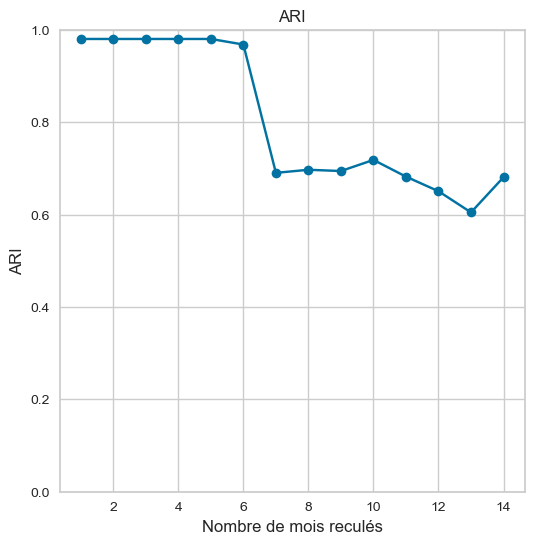

In [31]:
# Définir la période de référence
date_fin = pd.to_datetime('2018-05-31')
date_debut = date_fin - pd.Timedelta(days=180)

# Initialiser une liste pour stocker les indices ARI
ARI = []

# Boucle sur 14 itérations (de 1 à 14) pour tester différentes périodes de maintenance
for i in range(1, 15):
    # Calculer la date de début de la période de maintenance en reculant de 30 jours à chaque itération
    date_new = date_debut - pd.Timedelta(days=30*i)
    
    # Calculer la date de fin de la période de maintenance en ajoutant 180 jours
    date_new_fin = date_new + pd.Timedelta(days=180)
    
    # Filtrer les données pour inclure uniquement celles dans la période de maintenance
    filter_date = (data.date_derniere_commande > date_new) & (data.date_derniere_commande < date_new_fin) 
    data_filtered = data[filter_date].copy()
    
    # Vérifier si vous avez suffisamment de données pour appliquer QuantileTransformer
    if len(data_filtered) > 0:
        # Copier les colonnes pertinentes du DataFrame "data" dans un nouveau DataFrame "data_cluster"
        data_cluster = data[['nombre_de_commandes','note_par_commande','paye_par_commande','mean_délai_de_commande',
                             'livraison_par_commande','nb_paye_par_commande','mean_note_de_commentaire','mean_taille_de_commentaire','mois_de_vente','mean_nombre_articles',
                             'mean_délai_de_commande','livraison_par_commande','mean_prix_commande']].copy()

        # Appliquer la transformation log(1+x) sur les deux colonnes 
        data_cluster['paye_par_commande'] = np.log1p(data_cluster['paye_par_commande'])
        data_cluster['mean_délai_de_commande'] = np.log1p(data_cluster['mean_délai_de_commande'])

        # Copier les colonnes transformées dans un nouveau DataFrame
        transformed_columns = data_cluster[['paye_par_commande', 'mean_délai_de_commande', 'livraison_par_commande']].copy()

        # Appliquer la transformation QuantileTransformer aux colonnes copiées
        transformed_columns = QuantileTransformer(n_quantiles=5).fit_transform(transformed_columns)

        # Remplacer les colonnes d'origine dans le DataFrame data_cluster par les colonnes transformées
        data_cluster[['paye_par_commande', 'mean_délai_de_commande', 'livraison_par_commande']] = transformed_columns

        # Appliquer la transformation Min-Max aux données standardisées (X_std)
        X_std = MinMaxScaler().fit_transform(data_cluster)

        # Initialiser le modèle de clustering K-Means avec 8 clusters
        km_range = KMeans(n_clusters=8)

        # Entraîner le modèle sur les données standardisées
        km_range.fit(X_std)

        # Obtenir les labels prédits par le modèle
        cluster_predits = km_range.labels_

        # Calculer l'ARI en le comparant à un ensemble de labels de référence si disponible
        # Sinon, vous pouvez utiliser les labels prédits comme référence si cela a du sens dans votre application.
        ari = adjusted_rand_score(km.labels_, cluster_predits)  # Remplacez labels_de_reference par votre propre ensemble de labels de référence

        # Ajouter le score ARI à la liste ARI
        ARI.append(ari)
    else:
        # Ajouter une valeur par défaut si la liste ARI est vide
        ARI.append(0.98)

# Créer un graphique ARI    
plt.figure(figsize=(6,6))
plt.plot(range(1, 15), ARI, marker = 'o')
plt.title('ARI')
plt.xlabel('Nombre de mois reculés')
plt.ylabel('ARI')
plt.ylim((0,1))
plt.savefig('P2_14_ARI_maintenance.jpg')
plt.show()

### Conclusion:


Avec notre modèle, nous observons une chute de l'ARI après 6 mois. Cela signifie que les clients changent de clusters après cette période, ce qui entraîne une baisse du score ARI.

Par conséquent, la fréquence de maintenance du modèle est de 6 mois. Les clusters restent valides pendant cette période, mais au-delà, il est nécessaire de re-entraîner le modèle afin d'obtenir des clusters à jour et précis.